In [1]:
import torch
from torch import nn
from PIL import Image
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights

In [38]:
class RN50GradCAM(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        rn50 = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.avgpool = rn50.avgpool
        self.fc = rn50.fc
        rn50.avgpool = nn.Identity()
        rn50.fc = nn.Identity()
        self.rn50 = rn50
        self.gradients = None
    
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x: torch.Tensor):
        x = self.rn50.conv1(x)
        x = self.rn50.bn1(x)
        x = self.rn50.relu(x)
        x = self.rn50.maxpool(x)

        x = self.rn50.layer1(x)
        x = self.rn50.layer2(x)
        x = self.rn50.layer3(x)
        x = self.rn50.layer4(x)

        h = x.register_hook(self.activations_hook)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def forward_features(self, x: torch.Tensor):
        x = self.rn50.conv1(x)
        x = self.rn50.bn1(x)
        x = self.rn50.relu(x)
        x = self.rn50.maxpool(x)

        x = self.rn50.layer1(x)
        x = self.rn50.layer2(x)
        x = self.rn50.layer3(x)
        x = self.rn50.layer4(x)
        return x

In [39]:
im = Image.open('shark.webp').convert('RGB')
transform = T.Compose([T.Resize((224, 224)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
x = transform(im).unsqueeze(0)

In [47]:
net = RN50GradCAM()
net.eval()
pred = net(x)

In [48]:
max_logit = torch.max(pred)
max_logit.backward()

In [49]:
torch.argmax(pred)

tensor(2)

In [50]:
grad = net.gradients
grad_pooled = torch.mean(grad, dim=(0, 2, 3))
activations = net.forward_features(x).detach()

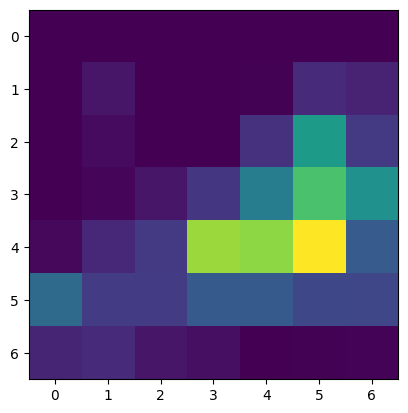

In [51]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(activations.shape[1]):
    activations[:, i, ...] *= grad_pooled[i]

heatmap = torch.mean(activations, dim=1).squeeze().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.imshow(heatmap.squeeze())

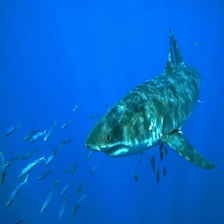

In [45]:
im.resize((224,224))